This notebook will run through how to use the gaussian process kernel with `george` to fit AT2017gfo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gaussian_process_example import *
from astropy.coordinates import Distance
import astropy.units as u

color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'blue'}

Here, we import the full dataframe of original observations and filter it down to just AT2017gfo as an example. As noted in the IIb or not IIb paper, these are not technically ZTF observations, but we employ the Pan-STARRS observations, whose filters have a similar wavelength sensitivity to those of ZTF.

In [2]:
df_obs = pd.read_csv('observed_data.csv')

at2017gfo = df_obs[df_obs['obj_id'] == 'AT2017gfo'].copy()
at2017gfo

,obj_id,type,redshift,mjd,mjd_0,t,mag_ztfg,abs_mag_ztfg,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi
0,AT2017gfo,Kilonova,0.00984,57983.231,57983.231,0.000,NaN,NaN,NaN,NaN,NaN,NaN,17.24,-15.97368,0.06
1,AT2017gfo,Kilonova,0.00984,57983.420,57983.231,0.189,17.46,-15.75368,0.08,NaN,NaN,NaN,NaN,NaN,NaN
2,AT2017gfo,Kilonova,0.00984,57983.420,57983.231,0.189,NaN,NaN,NaN,17.32,-15.89368,0.07,NaN,NaN,NaN
3,AT2017gfo,Kilonova,0.00984,57983.420,57983.231,0.189,NaN,NaN,NaN,NaN,NaN,NaN,17.42,-15.79368,0.05
4,AT2017gfo,Kilonova,0.00984,57983.758,57983.231,0.527,18.05,-15.16368,0.12,NaN,NaN,NaN,NaN,NaN,NaN
5,AT2017gfo,Kilonova,0.00984,57983.758,57983.231,0.527,NaN,NaN,NaN,17.89,-15.32368,0.03,NaN,NaN,NaN
6,AT2017gfo,Kilonova,0.00984,57983.969,57983.231,0.738,18.49,-14.72368,0.04,NaN,NaN,NaN,NaN,NaN,NaN
7,AT2017gfo,Kilonova,0.00984,57983.969,57983.231,0.738,NaN,NaN,NaN,17.99,-15.22368,0.01,NaN,NaN,NaN
8,AT2017gfo,Kilonova,0.00984,57983.969,57983.231,0.738,NaN,NaN,NaN,NaN,NaN,NaN,17.85,-15.36368,0.05
9,AT2017gfo,Kilonova,0.00984,57984.231,57983.231,1.000,NaN,NaN,NaN,NaN,NaN,NaN,17.87,-15.34368,0.06


Plotting the data below, one can see observations are not uniformly sampled across the 3 filters. This is problematic for calculating different metrics like the fade rate and color, as they require evenly sampled data.

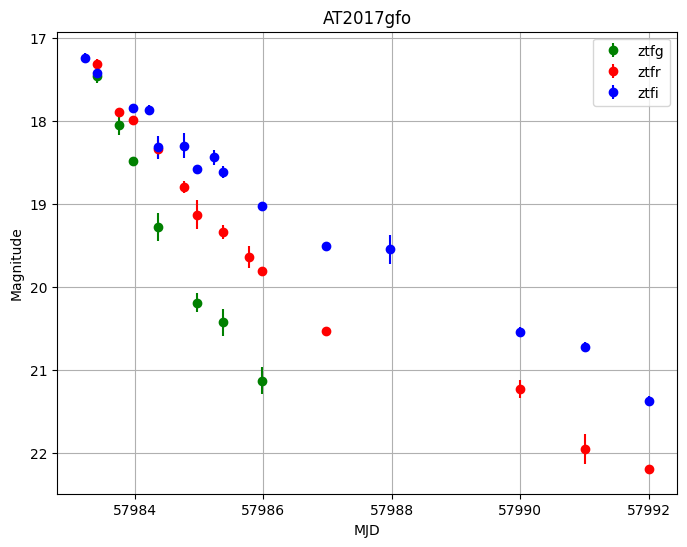

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
for filt in ['ztfg', 'ztfr', 'ztfi']:
    ax.errorbar(at2017gfo['mjd'], at2017gfo['mag_'+filt], yerr=at2017gfo['mag_error_'+filt], fmt='o', label=filt, color=color_dict[filt])
ax.set_xlabel('MJD')
ax.set_ylabel('Magnitude')
ax.set_title('AT2017gfo')
ax.legend()
ax.grid()
ax.invert_yaxis()
plt.show()

To make it easier to analyze, we use a Gaussian Process to create a smoothed lightcurve. The code for these functions are located in the `gaussian_process_example.py` file. Here, we define a set of functions to format and normalize the AT2017gfo data to match that expected by the GP fitting function.

In [4]:
def ingest_df(df):
    dfs = []
    for filt in ['ztfg', 'ztfr', 'ztfi']:
        temp_df = df[['obj_id', 'type', 'redshift', 'mjd', f'mag_{filt}', f'mag_error_{filt}']].copy()
        temp_df.columns = ['obj_id', 'type', 'redshift', 'mjd', 'mag', 'magerr']
        temp_df['filter'] = filt
        dfs.append(temp_df)
        
    return pd.concat(dfs, ignore_index=True).dropna(subset=['mag', 'magerr'])

def outgest_df(df):
    filters = df['filter'].unique()
    dfs = []
    for filt in filters:
        temp_df = df[df['filter'] == filt].copy()
        temp_df = temp_df[['obj_id', 'type', 'redshift', 'mjd', 'mag', 'magerr']]
        temp_df.columns = ['obj_id', 'type', 'redshift', 'mjd', f'mag_{filt}', f'mag_error_{filt}',f'flux_{filt}', f'flux_error_{filt}']
        dfs.append(temp_df)
        
    return dfs[0].merge(*dfs[1:], on=['obj_id', 'type', 'redshift', 'mjd'], how='outer')

def Mag2Flux(df):
    temp_df = df.dropna().copy()
    temp_df['flux'] = 10 ** (-0.4 * (temp_df['mag'] - 23.9))
    temp_df['flux_error'] = (temp_df['magerr'] / (2.5 / np.log(10))) * temp_df['flux']

    temp_df = temp_df[['obj_id', 'mjd', 'flux', 'flux_error', 'filter', 'type', 'redshift']]
    return temp_df

def Normalize(df):
    temp_df = df.dropna().copy()
    temp_df['mjd_0'] = temp_df.groupby('obj_id')['mjd'].transform(lambda x: np.min(x))
    temp_df['mjd'] = temp_df.groupby('obj_id')['mjd'].transform(lambda x: x - np.min(x))

    temp_df.reset_index(drop=True, inplace=True)
    return temp_df

In [5]:
at2017gfo_formatted = ingest_df(at2017gfo)
at2017gfo_formatted = Mag2Flux(at2017gfo_formatted)
at2017gfo_formatted = Normalize(at2017gfo_formatted)
at2017gfo_formatted

,obj_id,mjd,flux,flux_error,filter,type,redshift,mjd_0
0,AT2017gfo,0.189,376.703799,27.756562,ztfg,Kilonova,0.00984,57983.231
1,AT2017gfo,0.527,218.776162,24.180035,ztfg,Kilonova,0.00984,57983.231
2,AT2017gfo,0.738,145.881426,5.374470,ztfg,Kilonova,0.00984,57983.231
3,AT2017gfo,1.139,70.469307,11.033787,ztfg,Kilonova,0.00984,57983.231
4,AT2017gfo,1.738,30.478950,3.087937,ztfg,Kilonova,0.00984,57983.231
5,AT2017gfo,2.149,24.434306,3.600772,ztfg,Kilonova,0.00984,57983.231
6,AT2017gfo,2.743,12.823306,1.889712,ztfg,Kilonova,0.00984,57983.231
7,AT2017gfo,0.189,428.548520,27.629544,ztfr,Kilonova,0.00984,57983.231
8,AT2017gfo,0.527,253.512863,7.004819,ztfr,Kilonova,0.00984,57983.231
9,AT2017gfo,0.738,231.206479,2.129490,ztfr,Kilonova,0.00984,57983.231


Now, we apply the GP function with the provided kernel to create a smooth lightcurve for AT2017gfo in all filters.

In [6]:
kernel = load_kernel('kernel.pkl')
gp_at2017gfo = process_gaussian(at2017gfo_formatted, kernel=kernel, save=False, name='total', number_gp=1000)
gp_at2017gfo

Kernel loaded from kernel.pkl


,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id
0,0.000000,385.374906,440.341788,404.940209,29.250027,17.182907,24.797305,Kilonova,AT2017gfo
1,0.008778,382.559484,438.232033,402.502588,28.789575,16.890215,24.361032,Kilonova,AT2017gfo
2,0.017556,379.738177,436.119876,400.065220,28.332873,16.606597,23.927709,Kilonova,AT2017gfo
3,0.026333,376.910979,434.005567,397.628148,27.879986,16.332054,23.497397,Kilonova,AT2017gfo
4,0.035111,374.077886,431.889351,395.191413,27.430981,16.066587,23.070161,Kilonova,AT2017gfo
...,...,...,...,...,...,...,...,...,...
995,8.733889,-3.850415,10.608162,4.810292,221.610898,1.882051,1.810096,Kilonova,AT2017gfo
996,8.742667,-3.844360,10.525804,4.804540,221.799359,1.471459,1.375612,Kilonova,AT2017gfo
997,8.751444,-3.838300,10.443783,4.798623,221.988381,1.074120,0.934944,Kilonova,AT2017gfo
998,8.760222,-3.832235,10.362111,4.792535,222.177970,0.729042,0.495627,Kilonova,AT2017gfo


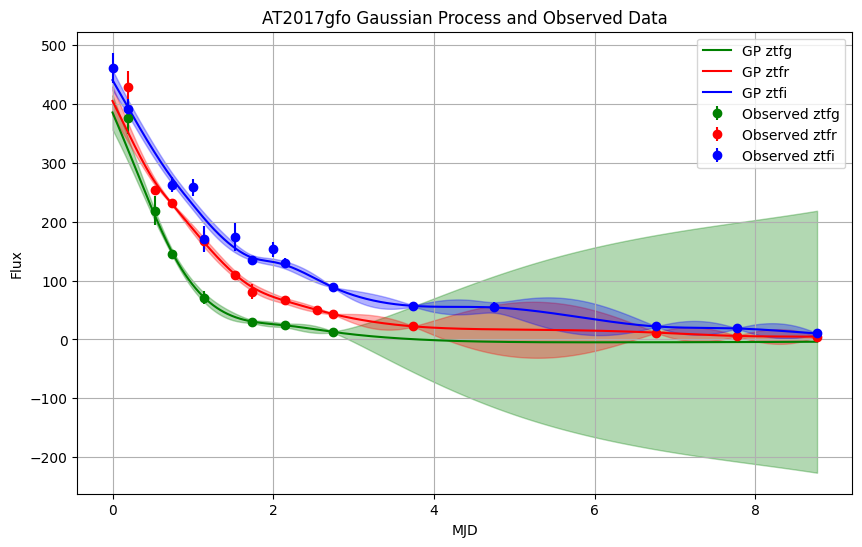

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
for filter_name in ['ztfg', 'ztfr', 'ztfi']:
    # Plot GP results
    ax.plot(gp_at2017gfo['mjd'], gp_at2017gfo[f'flux_{filter_name}'], label=f'GP {filter_name}', color=color_dict[filter_name])
    ax.fill_between(
        gp_at2017gfo['mjd'],
        gp_at2017gfo[f'flux_{filter_name}'] - gp_at2017gfo[f'flux_error_{filter_name}'],
        gp_at2017gfo[f'flux_{filter_name}'] + gp_at2017gfo[f'flux_error_{filter_name}'],
        color=color_dict[filter_name],
        alpha=0.3
    )
    # Plot original observed data
    ax.errorbar(
        at2017gfo_formatted[at2017gfo_formatted['filter'] == filter_name]['mjd'],
        at2017gfo_formatted[at2017gfo_formatted['filter'] == filter_name]['flux'],
        yerr=at2017gfo_formatted[at2017gfo_formatted['filter'] == filter_name]['flux_error'],
        fmt='o',
        label=f'Observed {filter_name}',
        color=color_dict[filter_name]
    )

ax.set_xlabel('MJD')
ax.set_ylabel('Flux')
ax.set_title('AT2017gfo Gaussian Process and Observed Data')
ax.legend()
ax.grid()

plt.show()

Comparing the GP results to the observed data, one can see that it is sampled evenly and with a high cadence, making analysis uniform and more consistent across objects even if the number of observations differs. From here, one can convert the GP back into magnitudes and use it for analysis.

This GP is applied to all objects listed in the paper. Results are saved in the `imposter_gp_lightcurves.csv` file. Additionally, `imposter_gp_lightcurves_downsample.csv` contains only the data used for calculating the metrics, so data on objects observed long after their peak is not included.

These lightcurves can now be used to calculate different metrics. A basic overview of this is shown in `metric_calculation_example.ipynb`.